# Linear, LASSO, & Ridge Regression

## Intro

This Jupyter noteboook focuses on making a linear regression on a Canadian car emission dataset that can be found here. The goal is to predict co2 car emissions by training the model on different car features. Then, the model is trained using differend forms of data standardization and the results are compared to find the optimal model.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

def get_co2_data():
    co2_data = pd.read_csv('CO2 Emissions_Canada.csv')
    #print(co2_data.dtypes)
    #print('\n')
    #print(co2_data.head)
    #co2_data['CO2 Emissions(g/km)'].hist()
        
    return co2_data
get_co2_data()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244
...,...,...,...,...,...,...,...,...,...,...,...,...
7380,VOLVO,XC40 T5 AWD,SUV - SMALL,2.0,4,AS8,Z,10.7,7.7,9.4,30,219
7381,VOLVO,XC60 T5 AWD,SUV - SMALL,2.0,4,AS8,Z,11.2,8.3,9.9,29,232
7382,VOLVO,XC60 T6 AWD,SUV - SMALL,2.0,4,AS8,Z,11.7,8.6,10.3,27,240
7383,VOLVO,XC90 T5 AWD,SUV - STANDARD,2.0,4,AS8,Z,11.2,8.3,9.9,29,232


## Normalization

Making the target normally distributed often leads to better results. D'Agostino's K^2 test is used to check for normalization.

In [3]:
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test
#Linear Regression assumes a normally distributed residuals which can be aided by transforming y variable which is the target variable
def data_normal_test():
    co2_data = get_co2_data()
    print(normaltest(co2_data['CO2 Emissions(g/km)'].values))
    
data_normal_test()

NormaltestResult(statistic=349.5238102344291, pvalue=1.264354797210247e-76)


p-value is extremely low. CO2 Emissions variable is not normally distributed.

### Boxcox Transform

One way to normalize the data is by using SciPy boxcox method.

NormaltestResult(statistic=5.137940214422628, pvalue=0.0766144094339886)


NormaltestResult(statistic=masked_array(data=[349.52381023442985],
             mask=[False],
       fill_value=1e+20), pvalue=array([1.2643548e-76]))


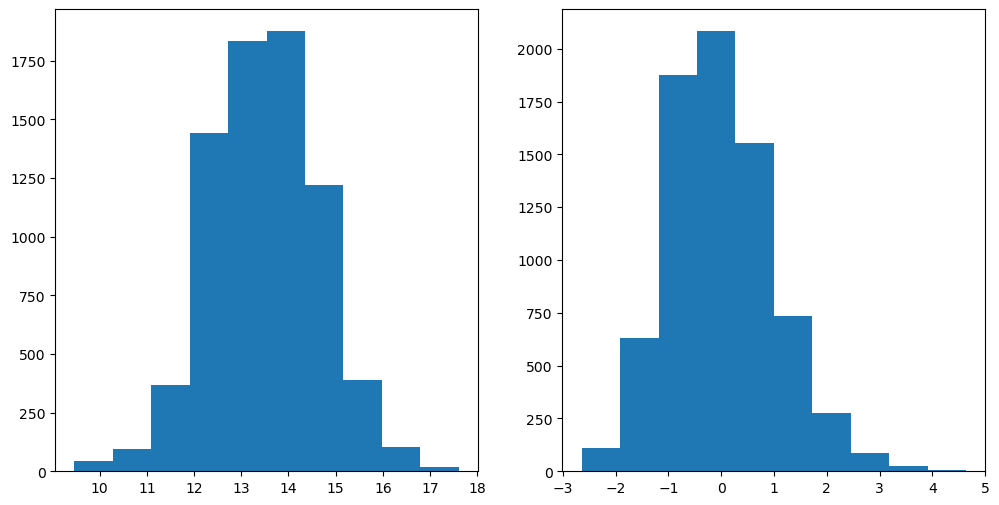

In [4]:
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler

def data_boxcox():
    co2_data = get_co2_data()
   
    CO2_boxcox, lam = boxcox(co2_data['CO2 Emissions(g/km)'])
    print(normaltest(CO2_boxcox))
    print('\n')
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].hist(CO2_boxcox)
    ss = StandardScaler()
    ss_co2_data = ss.fit_transform(co2_data[['CO2 Emissions(g/km)']])
    print(normaltest(ss_co2_data))
    ax[1].hist(ss_co2_data)
    
data_boxcox()

### Feature Selection

Transform categorical columns into numerical columns using sklearns OneHotEncoder methods.

In [5]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

def one_hot_enc_data():
    data = get_co2_data()
    data = data.drop('Model',axis=1)
    non_num_col = data.dtypes == object
    non_num_col = data.columns[non_num_col]

    # for col in data[non_num_col]:
        # unique_values = data[col].unique()
        # print(f'Unique values in column "{col}": {unique_values} \n')
        
    # Determine how many extra columns would be created
    num_onehot_cols = (data[non_num_col]
                .apply(lambda x: x.nunique())
                .sort_values(ascending=False))
    # print(num_onehot_cols)
    
    # Create a copy of the data so we can one hot encode it
    data_ohc = data.copy()
   
    
    le = LabelEncoder()
    ohc = OneHotEncoder()    
    
    for col in num_onehot_cols.index:
        
        # Integer encode the string categories
        le_data = le.fit_transform(data_ohc[col]).astype(int)
        
        # Remove orginal column from the data frame
        data_ohc = data_ohc.drop(col, axis = 1)
        
        # One hot encode the data, this returns a sparce array
        new_data = ohc.fit_transform(le_data.reshape(-1,1))
        
        #Create unique column names
        n_cols = new_data.shape[1]
        col_names = ['_'.join([col, str(x)]) for x in range(n_cols)]
        
        # Create a new data frame
        new_df = pd.DataFrame(new_data.toarray(), index = data_ohc.index, columns = col_names)
        
        # Append the new data to the dataframe
        data_ohc = pd.concat([data_ohc, new_df], axis = 1)
    
    return data_ohc

one_hot_enc_data()

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km),Make_0,Make_1,Make_2,...,Vehicle Class_11,Vehicle Class_12,Vehicle Class_13,Vehicle Class_14,Vehicle Class_15,Fuel Type_0,Fuel Type_1,Fuel Type_2,Fuel Type_3,Fuel Type_4
0,2.0,4,9.9,6.7,8.5,33,196,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2.4,4,11.2,7.7,9.6,29,221,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.5,4,6.0,5.8,5.9,48,136,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3.5,6,12.7,9.1,11.1,25,255,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3.5,6,12.1,8.7,10.6,27,244,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7380,2.0,4,10.7,7.7,9.4,30,219,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7381,2.0,4,11.2,8.3,9.9,29,232,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7382,2.0,4,11.7,8.6,10.3,27,240,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7383,2.0,4,11.2,8.3,9.9,29,232,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Linear Regression

There are multiple methods to normalize the data. Below there's a comparison of a linear regression model using different normalization methods.

### LR Using Boxcox

In [6]:
#Now that we have a normally distributed y-variable, let's test Regression using this transformed target variables.
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.special import inv_boxcox
from sklearn.metrics import r2_score
def LR_model():
    co2_data = one_hot_enc_data()#get_co2_data()
    y_col = 'CO2 Emissions(g/km)'
    
    X_data = co2_data.drop(y_col, axis = 1)
    Y_data = co2_data[y_col]
    
    #Lets add some plynomial features to fit our model to a function of degree 2
    polyfeat = PolynomialFeatures(degree = 2, include_bias=False)
    X_data_pf = polyfeat.fit_transform(X_data)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_data_pf,Y_data, test_size= 0.3)
    
    # Boxcox  transform Y_train
    Y_train_bc, lam = boxcox(Y_train)
    
    lr = LinearRegression()
    lr.fit(X_train,Y_train)
    y_pred_bc = lr.predict(X_test)
    
    #y_pred = inv_boxcox(y_pred_bc, lam)
    
    print(r2_score(Y_test, y_pred_bc))
    
LR_model()

0.9702208882003923


### Multiple Standardization Methods Comparison

In [7]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.metrics import mean_squared_error

def LR_Model_Comparison():
    data_ohc = one_hot_enc_data()
    #Split the data into x and y where y is the predicted variable
    y_col = 'CO2 Emissions(g/km)'
    
    feature_cols = [i for i in data_ohc.columns if i != y_col]
    LR_X_data = data_ohc[feature_cols]
    LR_Y_data = data_ohc[y_col]
    
    LR_X_train, LR_X_test, LR_Y_train, LR_Y_test = train_test_split(LR_X_data,LR_Y_data, test_size=0.3)
    
    LR = LinearRegression()
        
    error_com_df = {}
    
    scalers = {
        'Standard': StandardScaler(),
        'MinMax': MinMaxScaler(),
        'MaxAbs': MaxAbsScaler()}
    
    for scaler_label, scaler in scalers.items():
        training_set = LR_X_train.copy()
        test_set = LR_X_test.copy()
        
        tarining_set = scaler.fit_transform(training_set)
        test_set = scaler.transform(test_set)
        LR.fit(tarining_set, LR_Y_train)
        predictions = LR.predict(test_set)
        key = scaler_label + 'scaling'
        error_com_df[key] = mean_squared_error(LR_Y_test, predictions)
        
        print(scaler_label, r2_score(LR_Y_test, predictions))
        
    error_com_df = pd.Series(error_com_df)
    print('\n')
    print(error_com_df.to_string())
    print('\n')
    for key, error_val in error_com_df.items():
        print(key, error_val)
        
LR_Model_Comparison()

Standard -5.898317248973097e+18
MinMax -6.080427179556927e+17
MaxAbs -1.121058479230575e+19


Standardscaling    1.943449e+22
MinMaxscaling      2.003453e+21
MaxAbsscaling      3.693800e+22


Standardscaling 1.943449263755762e+22
MinMaxscaling 2.0034530573084698e+21
MaxAbsscaling 3.693799746812758e+22


## Cross Validation

Cross-validation is a statistical technique used to evaluate the performance of a predictive model. For this notebook it involves dividing the dataset into multiple subsets. The model is trained and tested using all subsets, this ensures that the model performance is evaluated and tested agains all data points.

First we divide the data into k number of subsets, then for each subset, the model is trained on k-1 subsets and is tested on the remaining set. Lastly, the model performance is evaluated, allowing evaluation of the average performance of the model using different train and test sets, reducing the likelihood of overfitting and providing a more reliable estimate of the model's performance.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_predict

def LR_Cross_Val():
    data_ohc = one_hot_enc_data()
    
    
    #Split the data into x and y where y is the predicted variable
    y_col = 'CO2 Emissions(g/km)'
    
    feature_cols = [i for i in data_ohc.columns if i != y_col]
    X_data = data_ohc[feature_cols]
    Y_data = data_ohc[y_col]
    
    kf = KFold(shuffle = True, n_splits = 4)
    
    scores = []
    
    lr = LinearRegression()
    
    for train_index, test_index in kf.split(X_data):
        X_train, X_test, Y_train, Y_test = (X_data.iloc[train_index, :], X_data.iloc[test_index, :],
                                           Y_data.iloc[train_index], Y_data.iloc[test_index])
        lr.fit(X_train, Y_train)
        
        y_pred = lr.predict(X_test)
        score = r2_score(Y_test.values, y_pred)
        
        scores.append(score)
        
    print(scores)
LR_Cross_Val()

[0.9931683111932453, 0.9930570648491762, 0.9931557722431743, 0.9938421463546347]


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_predict

def LR_Cross_Val2():
    data_ohc = one_hot_enc_data()
    
    
    #Split the data into x and y where y is the predicted variable
    y_col = 'CO2 Emissions(g/km)'
    
    feature_cols = [i for i in data_ohc.columns if i != y_col]
    X_data = data_ohc[feature_cols]
    Y_data = data_ohc[y_col]
    
    kf = KFold(shuffle = True, n_splits = 4)
    
    scores = []
    
    lr = LinearRegression()
    ss = StandardScaler()
    
    for train_index, test_index in kf.split(X_data):
        X_train, X_test, Y_train, Y_test = (X_data.iloc[train_index, :], X_data.iloc[test_index, :],
                                           Y_data.iloc[train_index], Y_data.iloc[test_index])
        X_train_ss = ss.fit_transform(X_train)
        X_test_ss = ss.transform(X_test)
        lr.fit(X_train_ss, Y_train)
        
        y_pred = lr.predict(X_test_ss)
        score = r2_score(Y_test.values, y_pred)
        
        scores.append(score)
        
    print(scores)
LR_Cross_Val2()

[0.9938477051628687, 0.9927352380609155, -1.8064039592826592e+17, 0.994294847461928]


## Regularization

### Hyperparameter Tunning

Hyperparameter tunning uses cross validation to determine which hyperparameters are most likely to create a model that works well with data that's different from the training and test sets provided.

### LASSO Regression

C:\Users\palom\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.493e+04, tolerance: 1.870e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\palom\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.493e+04, tolerance: 1.908e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\palom\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.312e+04, toleranc

[0.9973346695698733, 0.9972737245379328, 0.997500131835332, 0.997566431146508, 0.9953181278698786]


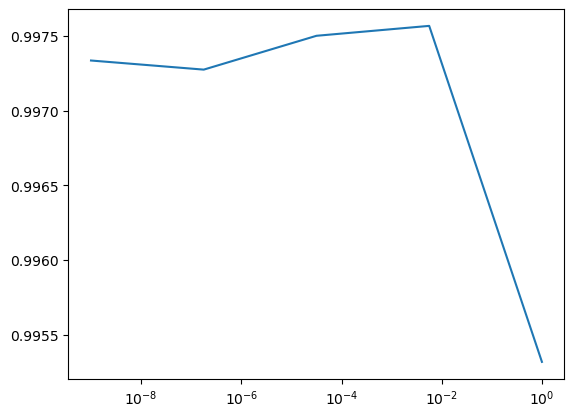

In [9]:
from sklearn.linear_model import Lasso

def Lasso_Reg():
    data_ohc = one_hot_enc_data()
    y_col = 'CO2 Emissions(g/km)'
    
    feature_cols = [i for i in data_ohc.columns if i != y_col]
    X_data = data_ohc[feature_cols]
    Y_data = data_ohc[y_col]
    
    scores  = []
    
    polyfeat = PolynomialFeatures(degree = 2)
    standscale = StandardScaler()
    
    kf = KFold(shuffle = True, n_splits = 4)
    
    alphas = np.geomspace(1e-9, 1, num = 5)
    
    for alpha in alphas:
        lasso_reg = Lasso(alpha, max_iter = 1000)
        
        model = Pipeline([('Polynomial Features', polyfeat),
                        ('Standard Scaler', standscale),
                        ('Lasso Regression', lasso_reg)])
    
        predictions = cross_val_predict(model, X_data, Y_data, cv = kf)
        
        score = r2_score(Y_data, predictions)
        
        scores.append(score)
    
    print(scores)
    
    plt.semilogx(alphas, scores);
Lasso_Reg()

### Ridge Regression

[0.9970822433449268, 0.9973489002416306, 0.9974452589438307, 0.9975770963391751, 0.9974736572484472]


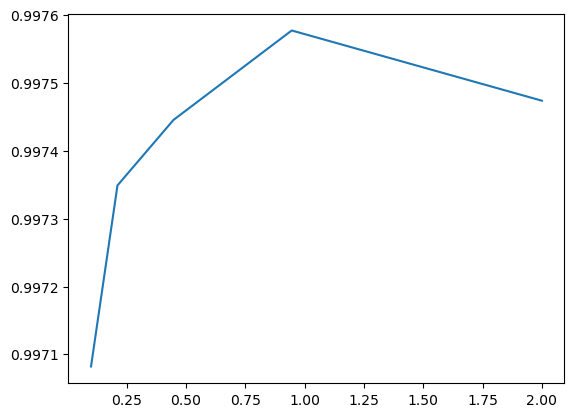

In [12]:
from sklearn.linear_model import Ridge

def Ridge_Reg():
    data_ohc = one_hot_enc_data()
    y_col = 'CO2 Emissions(g/km)'
    
    feature_cols = [i for i in data_ohc.columns if i != y_col]
    X_data = data_ohc[feature_cols]
    Y_data = data_ohc[y_col]
    
    scores  = []
    
    polyfeat = PolynomialFeatures(degree = 2)
    standscale = StandardScaler()
    
    kf = KFold(shuffle = True, n_splits = 4)
    
    alphas = np.geomspace(0.1, 2, 5)
    
    for alpha in alphas:
        RidgeReg = Ridge(alpha = alpha, max_iter=1000)
        
        model = Pipeline([('Polynomial Features', polyfeat),
                          ('Standard Scaler', standscale),
                          ('Ridge Regression', RidgeReg)])
    
        predictions = cross_val_predict(model, X_data, Y_data, cv = kf)
        
        score = r2_score(Y_data, predictions)
        
        scores.append(score)
    
    print(scores)
    
    plt.plot(alphas, scores);
Ridge_Reg()

###  Grid Search CV

GridSearchCV takes a model (or pipeline) with a dictionary of parameters to scan over. It finds the hyperparameter set that has the best out-of-sample score on all the parameters, and calls it "best estimator". Then it trains again on all data with the best hyper-parameters.

In [ ]:
from sklearn.model_selection import GridSearchCV

def Ridge_Grid_Search():
    data_ohc = one_hot_enc_data()
    y_col = 'CO2 Emissions(g/km)'
    
    feature_cols = [i for i in data_ohc.columns if i != y_col]
    X_data = data_ohc[feature_cols]
    Y_data = data_ohc[y_col]
    
    kf = KFold(shuffle = True, n_splits = 4)
    
    model = Pipeline([("polynomial_features", PolynomialFeatures()),
        ("scaler", StandardScaler()),
        ("ridge_regression", Ridge())])
    
    params = {'polynomial_features__degree': [1,2,3],
              'ridge_regression__alpha': np.geomspace(4,20, 10)
             }
    
    grid_search = GridSearchCV(model, params, cv = kf)
    grid_search.fit(X_data, Y_data)

    print(grid_search.best_estimator_, grid_search.best_params_)
    y_predict = grid_search.predict(X_data)
    print(r2_score(Y_data, y_predict))
    
Ridge_Grid_Search()

### Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNetCV